# Facility Location for temporal markets using PuLP and UrbanPy

### General imports

In [1]:
# import warnings

# warnings.filterwarnings("ignore")

In [2]:
# import sys

# sys.path.append("..")
import urbanpy as up
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import numpy as np
import re
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pulp import *
from tqdm.auto import tqdm

In [ ]:
tqdm.pandas()

### Data preparation

First, we need our set of possible facilities to activate. To construct it we will

* Download a administrative limits from one district of Lima, Peru: San Juan de Lurigancho
* Download parks and pitches in the area from OpenStreetMap (OSM)

In [3]:
florianopolis = up.download.nominatim_osm("Florianopolis, Brazil")

In [4]:
florianopolis.crs.to_epsg()

4326

<Axes: >

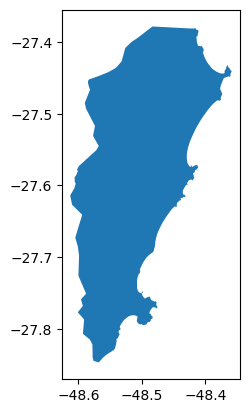

In [5]:
florianopolis.plot()

In [6]:
florianopolis_hexs = up.geom.gen_hexagons(8, florianopolis)

In [7]:
print("Number of Hexagons", florianopolis_hexs.shape[0])

Number of Hexagons 977


<Axes: >

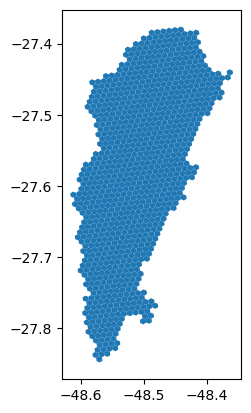

In [8]:
florianopolis_hexs.plot()

### Add external data to your UrbanPy workflow

Now we are going to load schools data from Brazil.

In [9]:
schools = pd.read_csv("data/escuelas.csv", skiprows=1)
display(schools.head())
print("Rows #", schools.shape[0], "| Columns #", schools.shape[1])
print("Columns names:", schools.columns)

,Restrição de Atendimento,Escola,UF,Município,Localização,Categoria Administrativa,Dependência Administrativa,Categoria Escola Privada,Conveniada Poder Público,Regulamentação pelo Conselho de Educação,Porte da Escola,Etapas e Modalidade de Ensino Oferecidas,Outras Ofertas Educacionais,LAT_FINAL,LONG_FINAL,Matriculas totales,Matrículas oficiales
0,ESCOLA ATENDE EXCLUSIVAMENTE ALUNOS COM DEFICI...,EEEE ABNAEL MACHADO DE LIMA - CENE,RO,Porto Velho,Urbana,Pública,Estadual,Não Informado,Não,Não,Entre 51 e 200 matrículas de escolarização,Ensino Fundamental,Atendimento Educacional Especializado,-8.758459,-63.854011,159.0,94.0
1,ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...,CENTRO DE ENSINO CLASSE A,RO,Porto Velho,Urbana,Privada,Privada,Particular,Não,Sim,Mais de 1000 matrículas de escolarização,"Educação Infantil, Ensino Fundamental, Ensino ...",NaN,-8.760734,-63.901986,1433.0,1433.0
2,ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...,CENTRO EDUCACIONAL PRESBITERIANO 15 DE NOVEMBRO,RO,Porto Velho,Urbana,Privada,Privada,Particular,Não,Sim,Entre 51 e 200 matrículas de escolarização,"Educação Infantil, Ensino Fundamental",NaN,-8.765205,-63.896177,59.0,59.0
3,ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...,CENTRO EDUC CORA CORALINA,RO,Porto Velho,Urbana,Privada,Privada,Particular,Não,Sim,Entre 501 e 1000 matrículas de escolarização,"Educação Infantil, Ensino Fundamental",NaN,-8.768633,-63.875471,636.0,636.0
4,ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...,CENTRO EDUCACIONAL MOJUCA,RO,Porto Velho,Urbana,Privada,Privada,Particular,Não,Sim,Entre 201 e 500 matrículas de escolarização,"Ensino Fundamental, Ensino Médio",NaN,-8.765028,-63.891857,290.0,290.0


Rows # 215579 | Columns # 17
Columns names: Index(['Restrição de Atendimento', 'Escola', 'UF', 'Município', 'Localização',
       'Categoria Administrativa', 'Dependência Administrativa',
       'Categoria Escola Privada', 'Conveniada Poder Público',
       'Regulamentação pelo Conselho de Educação', 'Porte da Escola',
       'Etapas e Modalidade de Ensino Oferecidas',
       'Outras Ofertas Educacionais', 'LAT_FINAL', 'LONG_FINAL',
       'Matriculas totales', 'Matrículas oficiales'],
      dtype='object')


In [10]:
schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LONG_FINAL"], schools["LAT_FINAL"]),
    crs=4326,
)

<Axes: >

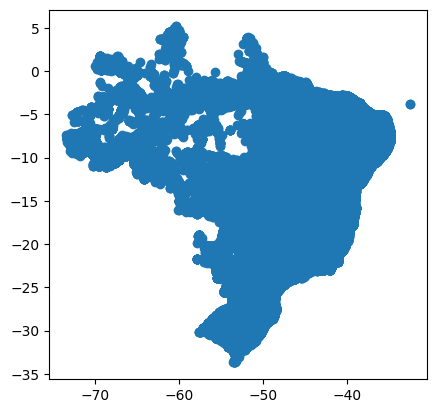

In [11]:
schools_gdf.plot()

In [12]:
print("Number of schools in Florianopolis:")
schools_gdf.within(florianopolis.geometry[0]).value_counts()[True]

Number of schools in Florianopolis:


341

Now we are going to create a custom query for the overpass api to download schools within the city polygon. We will use the OSM tagging system create our query. 

As primary feature (or top-level tag) we will use "amenity": Amenities are used to map facilities used by visitors and residents. For example: toilets, telephones, banks, pharmacies, cafes, parking and **schools**. 

As value we will use "school" that contains nodes (points) or areas of school and grounds - **primary, middle and seconday** schools.

- [See more information about possible top-level tags and values here](https://wiki.openstreetmap.org/wiki/Map_features)
- [You can try your own cutom querys interactively here](https://overpass-turbo.eu/).

In [13]:
osm_schools_gdf, _ = up.download.overpass(
    type_of_data="node", query={"amenity": ["school"]}, mask=florianopolis
)

In [14]:
osm_schools_gdf.head()

,type,id,lat,lon,tags,geometry,poi_type
8,node,2084038562,-27.702569,-48.536224,"{'access': 'yes', 'addr:housenumber': '3000', ...",POINT (-48.53622 -27.70257),school
20,node,6977011587,-27.701229,-48.509768,"{'amenity': 'school', 'name': 'Colégio Campeche'}",POINT (-48.50977 -27.70123),school
9,node,2167439573,-27.666141,-48.528988,"{'amenity': 'school', 'name': 'Escola Sabedori...",POINT (-48.52899 -27.66614),school
3,node,1454993590,-27.599978,-48.511266,"{'amenity': 'school', 'name': 'Colégio COC'}",POINT (-48.51127 -27.59998),school
23,node,11188052344,-27.599687,-48.546657,"{'addr:city': 'Florianópolis', 'addr:housenumb...",POINT (-48.54666 -27.59969),school


In [15]:
osm_schools_gdf.poi_type.value_counts()

poi_type
school             14
language_school     4
driving_school      3
music_school        1
Name: count, dtype: int64

We only obtained 14 schools from OSM, while we have 341 schools in our dataset. Lets visualize both schools points together.

In [16]:
osm_schools_gdf = osm_schools_gdf[osm_schools_gdf["poi_type"] == "school"]

<Axes: >

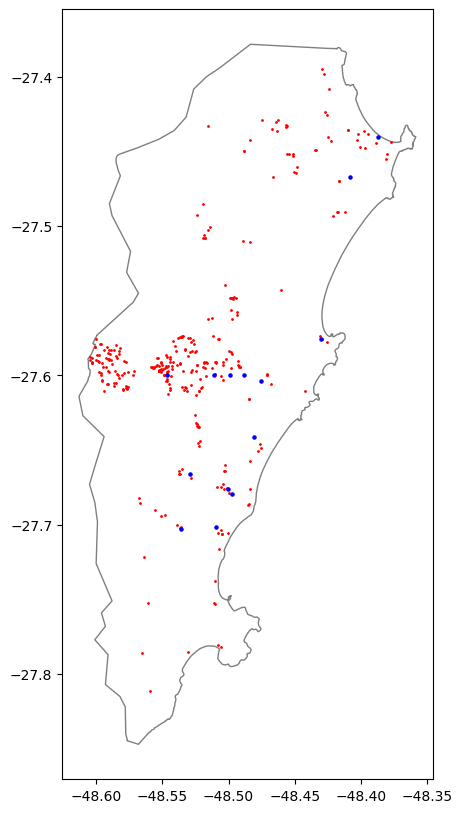

In [17]:
ax = florianopolis.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", facecolor="none")
schools_gdf[schools_gdf.within(florianopolis.geometry[0])].plot(ax=ax, color="red", markersize=1)
osm_schools_gdf.plot(ax=ax, color="blue", markersize=5)


Given that there are much more schools in the brazilian schools dataset than in the OSM data, we will use the first to continue with the analysis.

In [18]:
florianopolis_schools = schools_gdf[schools_gdf.within(florianopolis.geometry[0])]

In [20]:
florianopolis_schools.dtypes

Restrição de Atendimento                      object
Escola                                        object
UF                                            object
Município                                     object
Localização                                   object
Categoria Administrativa                      object
Dependência Administrativa                    object
Categoria Escola Privada                      object
Conveniada Poder Público                      object
Regulamentação pelo Conselho de Educação      object
Porte da Escola                               object
Etapas e Modalidade de Ensino Oferecidas      object
Outras Ofertas Educacionais                   object
LAT_FINAL                                    float64
LONG_FINAL                                   float64
Matriculas totales                           float64
Matrículas oficiales                         float64
geometry                                    geometry
dtype: object

In [23]:
florianopolis_schools["Restrição de Atendimento"].value_counts()

Restrição de Atendimento
ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATENDIMENTO       280
ESCOLA PARALISADA                                             32
ESCOLA EXCLUSIVA DE ATIVIDADE COMPLEMENTAR                    27
ESCOLA EXCLUSIVA DE ATENDIMENTO EDUCACIONAL ESPECIALIZADO      2
Name: count, dtype: int64

In [24]:
florianopolis_schools["Localização"].value_counts()

Localização
Urbana    335
Rural       6
Name: count, dtype: int64

In [25]:
florianopolis_schools["Categoria Administrativa"].value_counts()

Categoria Administrativa
Pública    176
Privada    165
Name: count, dtype: int64

In [26]:
florianopolis_schools["Dependência Administrativa"].value_counts()

Dependência Administrativa
Privada      165
Municipal    128
Estadual      44
Federal        4
Name: count, dtype: int64

In [27]:
florianopolis_schools["Categoria Escola Privada"].value_counts()

Categoria Escola Privada
Não Informado    199
Particular        96
Filantrópica      34
Comunitária       11
Confessional       1
Name: count, dtype: int64

In [28]:
florianopolis_schools["Conveniada Poder Público"].value_counts()

Conveniada Poder Público
Não    305
Sim     36
Name: count, dtype: int64

In [29]:
florianopolis_schools["Regulamentação pelo Conselho de Educação"].value_counts()


Regulamentação pelo Conselho de Educação
Sim              305
Em Tramitação      2
Não                2
Name: count, dtype: int64

In [30]:
florianopolis_schools["Porte da Escola"].value_counts()


Porte da Escola
Entre 51 e 200 matrículas de escolarização      112
Entre 201 e 500 matrículas de escolarização      85
Entre 501 e 1000 matrículas de escolarização     47
Escola sem matrícula de escolarização            29
Até 50 matrículas de escolarização               19
Mais de 1000 matrículas de escolarização         17
Name: count, dtype: int64

In [31]:
florianopolis_schools["Etapas e Modalidade de Ensino Oferecidas"].value_counts()


Etapas e Modalidade de Ensino Oferecidas
Educação Infantil                                          124
Ensino Fundamental                                          42
Educação Infantil, Ensino Fundamental                       39
Ensino Fundamental, Ensino Médio                            23
Educação Infantil, Ensino Fundamental, Ensino Médio         20
Ensino Médio                                                12
Educação Profissional                                        8
Educação de Jovens Adultos                                   6
Ensino Fundamental, Ensino Médio, Educação Profissional      2
Ensino Médio, Educação Profissional                          2
Educação Infantil, Educação de Jovens Adultos                1
Educação Profissional, Educação de Jovens Adultos            1
Name: count, dtype: int64

In [32]:
florianopolis_schools["Outras Ofertas Educacionais"].value_counts()


Outras Ofertas Educacionais
Atendimento Educacional Especializado                            39
Atividade Complementar                                           38
Atendimento Educacional Especializado, Atividade Complementar    18
Name: count, dtype: int64

<Axes: >

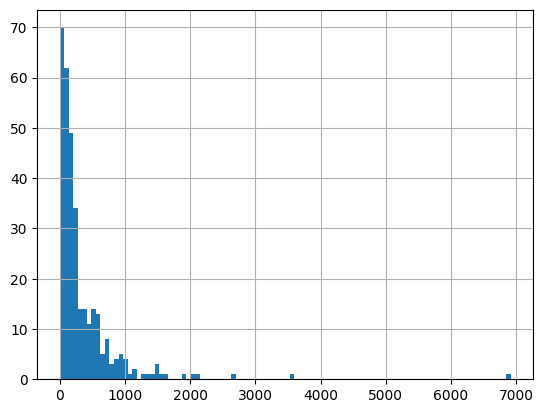

In [33]:
florianopolis_schools["Matriculas totales"].hist(bins=100)


<Axes: >

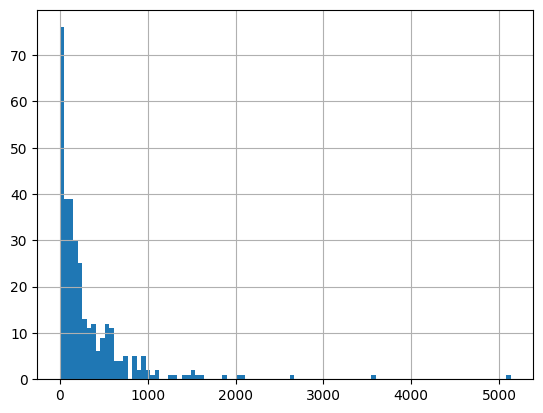

In [34]:
florianopolis_schools["Matrículas oficiales"].hist(bins=100)

In [35]:
(florianopolis_schools["Matriculas totales"] - florianopolis_schools["Matrículas oficiales"]).describe()

count     327.000000
mean       18.629969
std       104.544766
min         0.000000
25%         0.000000
50%         0.000000
75%         8.500000
max      1786.000000
dtype: float64

<Axes: >

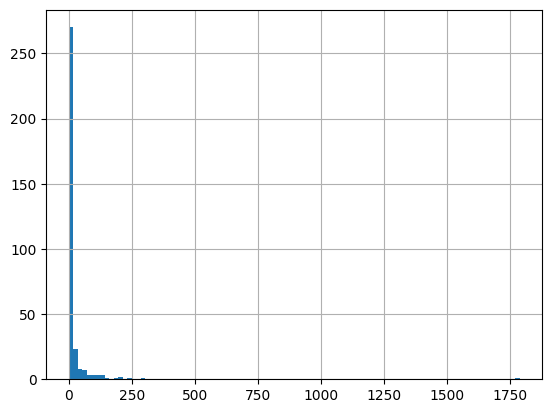

In [36]:
(florianopolis_schools["Matriculas totales"] - florianopolis_schools["Matrículas oficiales"]).hist(bins=100)

Approximate the school capacity using the "Matrículas oficiales" columns

In [37]:
florianopolis_schools["Matrículas oficiales"].describe()

count     327.000000
mean      323.253823
std       495.800889
min         0.000000
25%        62.500000
50%       165.000000
75%       411.000000
max      5133.000000
Name: Matrículas oficiales, dtype: float64

<Axes: >

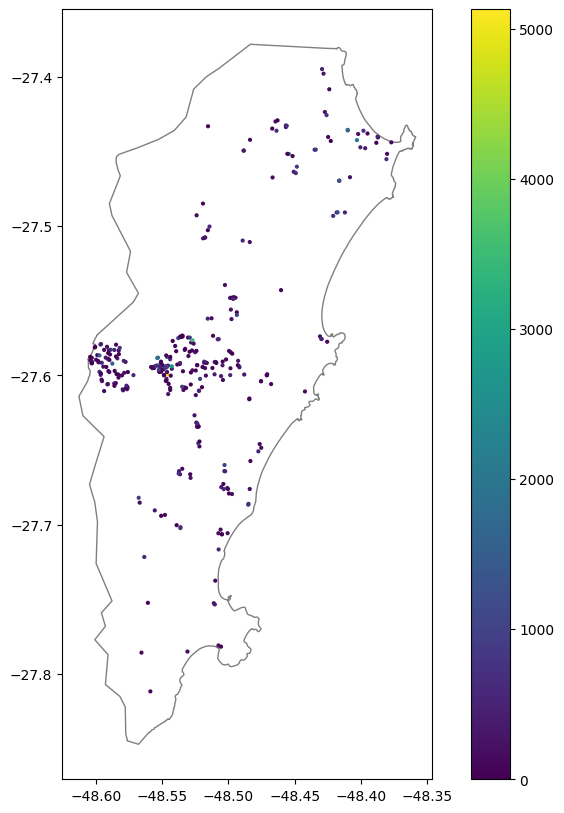

In [38]:
ax = florianopolis.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", facecolor="none")
florianopolis_schools.plot(column="Matrículas oficiales", legend=True, ax=ax, markersize=4)

In [40]:
florianopolis_schools.columns

Index(['Restrição de Atendimento', 'Escola', 'UF', 'Município', 'Localização',
       'Categoria Administrativa', 'Dependência Administrativa',
       'Categoria Escola Privada', 'Conveniada Poder Público',
       'Regulamentação pelo Conselho de Educação', 'Porte da Escola',
       'Etapas e Modalidade de Ensino Oferecidas',
       'Outras Ofertas Educacionais', 'LAT_FINAL', 'LONG_FINAL',
       'Matriculas totales', 'Matrículas oficiales', 'geometry'],
      dtype='object')

In [41]:
florianopolis_hexs = up.geom.merge_shape_hex(
    hexs=florianopolis_hexs, 
    shape=florianopolis_schools.reset_index(),
    agg={
        "Matriculas totales": "sum",
        "index": "count",
    },
).rename(columns={"index": "schools_count"}).fillna(0)

In [42]:
florianopolis_hexs.head()

,hex,geometry,Matriculas totales,schools_count
0,88a91b4727fffff,"POLYGON ((-48.48991 -27.58518, -48.48573 -27.5...",0.0,0.0
1,88a91b791dfffff,"POLYGON ((-48.50208 -27.40434, -48.49790 -27.4...",0.0,0.0
2,88a91b7867fffff,"POLYGON ((-48.52713 -27.42023, -48.52296 -27.4...",0.0,0.0
3,88a91b45abfffff,"POLYGON ((-48.52070 -27.50054, -48.51653 -27.4...",139.0,1.0
4,88a91b4555fffff,"POLYGON ((-48.50435 -27.55962, -48.50018 -27.5...",0.0,0.0


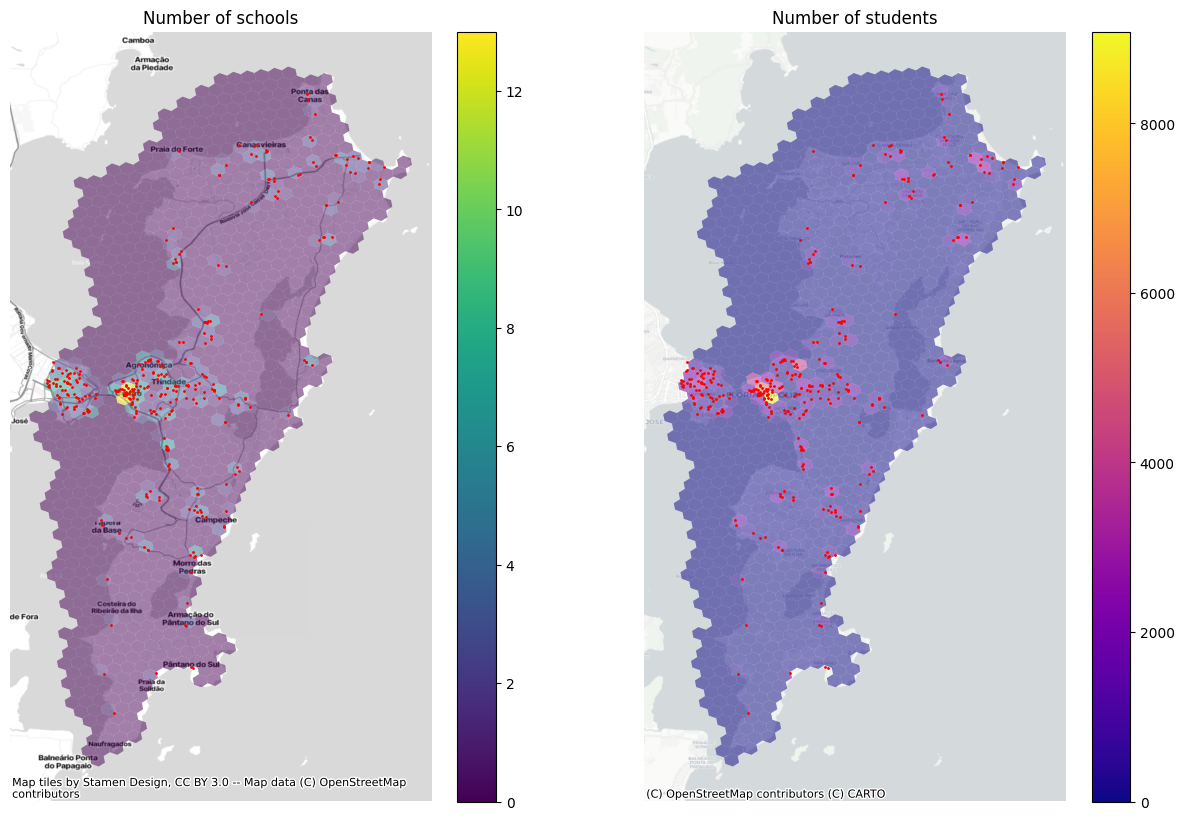

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

florianopolis_hexs.plot(column="schools_count", alpha=0.5, legend=True, ax=ax1)
florianopolis_schools.plot(ax=ax1, color="red", markersize=1)
ax1.set_title("Number of schools")
cx.add_basemap(ax1, crs=florianopolis_hexs.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax1.set_axis_off()

ax2.set_title("Number of students")
florianopolis_hexs.plot(column="Matriculas totales", alpha=0.5, cmap="plasma", legend=True, ax=ax2)
florianopolis_schools.plot(ax=ax2, color="red", markersize=1)
cx.add_basemap(ax2, crs=florianopolis_hexs.crs.to_string(), source=cx.providers.CartoDB.Positron)
ax2.set_axis_off()

In [59]:
print(
    "Number of hexagons without students:",
    florianopolis_hexs[florianopolis_hexs["Matriculas totales"] == 0].shape[0]
)

Number of hexagons without students: 843


In [60]:
print(
    "Number of hexagons without schools:",
    florianopolis_hexs[florianopolis_hexs["schools_count"] == 0].shape[0]
)

Number of hexagons without schools: 841


Now, we need to estimate the total population living close to schools. To achieve this we need to:

1. Download HDX data
2. Filter it to our district
3. Convert it to hexagons

In [51]:
pop_resources_df = up.download.search_hdx_dataset("brazil")
pop_resources_df

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,BRA_children_under_five_2019-06-01_csv.zip,Children (ages 0-5),159.14,https://data.humdata.org/dataset/c17003d1-47f4...
1,2019-06-11,BRA_elderly_60_plus_2019-06-01_csv.zip,Elderly (ages 60+),159.42,https://data.humdata.org/dataset/c17003d1-47f4...
2,2019-06-11,BRA_men_2019-06-01_csv.zip,Men,160.20,https://data.humdata.org/dataset/c17003d1-47f4...
26,2019-06-11,BRA_women_2019-06-01_csv.zip,Women,160.21,https://data.humdata.org/dataset/c17003d1-47f4...
27,2019-06-11,BRA_women_of_reproductive_age_15_49_2019-06-01...,Women of reproductive age (ages 15-49),160.03,https://data.humdata.org/dataset/c17003d1-47f4...
28,2019-06-11,BRA_youth_15_24_2019-06-01_csv.zip,Youth (ages 15-24),159.79,https://data.humdata.org/dataset/c17003d1-47f4...
33,2019-06-25,population_bra_northeast_2018-10-01.csv..zip,Overall population density,71.24,https://data.humdata.org/dataset/c17003d1-47f4...
34,2019-06-25,population_bra_northwest_2018-10-01.csv.zip,Overall population density,13.46,https://data.humdata.org/dataset/c17003d1-47f4...
35,2019-06-25,population_bra_southeast_2018-10-01.csv.zip,Overall population density,159.42,https://data.humdata.org/dataset/c17003d1-47f4...


In [52]:
pop = up.download.get_hdx_dataset(pop_resources_df, 28)

In [53]:
pop_florianopolis = up.geom.filter_population(pop, florianopolis)

Merging both layers

In [54]:
pop_florianopolis.isna().sum()

latitude      0
longitude     0
population    0
geometry      0
dtype: int64

In [55]:
florianopolis_hexs.isna().sum()

hex                   0
geometry              0
Matriculas totales    0
schools_count         0
dtype: int64

In [ ]:
florianopolis_hexs = up.geom.merge_shape_hex(
    florianopolis_hexs,
    pop_florianopolis,
    predicate="intersects",
    agg={"population": "sum"},
).fillna(0)

In [74]:
florianopolis_hexs.isna().sum()

hex                   0
geometry              0
Matriculas totales    0
schools_count         0
population            0
dtype: int64

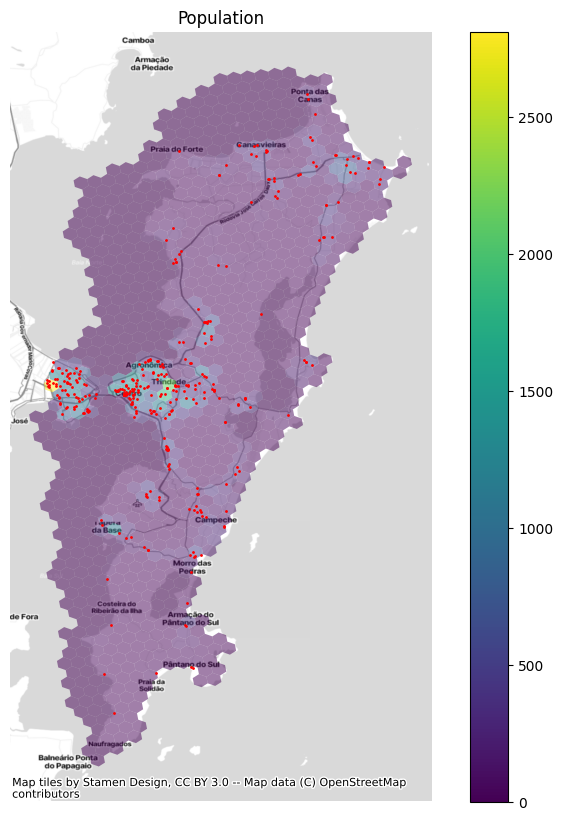

In [75]:
ax = florianopolis_hexs.plot(column="population", alpha=0.5, legend=True, figsize=(10, 10))
florianopolis_schools.plot(ax=ax, color="red", markersize=1)
ax.set_title("Population")
cx.add_basemap(ax, crs=florianopolis_hexs.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [76]:
print(
    "Number of hexagons without youth population:",
    florianopolis_hexs[florianopolis_hexs["population"] == 0].shape[0]
)

Number of hexagons without youth population: 485


Create the candidate hexagons set for locating the new schools

In [77]:
florianopolis_hexs["population"].describe()

,Matriculas totales,schools_count,population
count,977.000000,977.000000,977.000000
mean,113.603889,0.343910,83.791259
std,502.899337,1.136416,231.557536
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.225845
75%,0.000000,0.000000,47.690183
max,9082.000000,13.000000,2810.861110


Our candidates will be defined as hexagons that:

1. Currently don't have schools or students
2. Have youth population



In [80]:
candidates_hexs = florianopolis_hexs[(florianopolis_hexs["schools_count"] == 0) & (florianopolis_hexs["Matriculas totales"] == 0)]
candidates_hexs = candidates_hexs[candidates_hexs["population"] > 0]
print("Number of candidates hexs:", candidates_hexs.shape[0])


Number of candidates hexs: 356


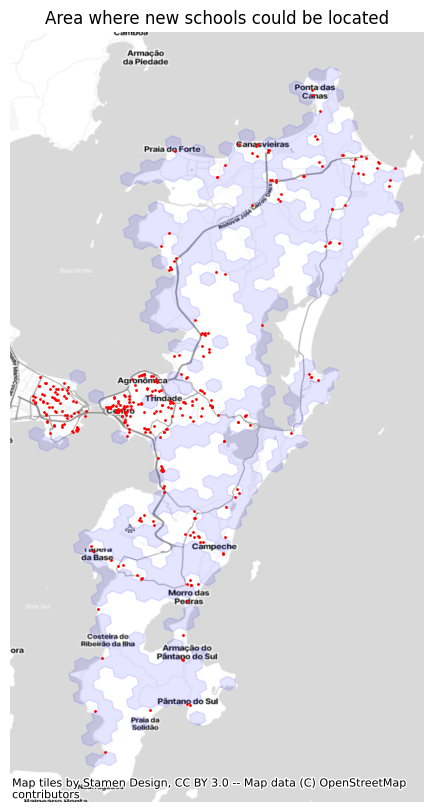

In [86]:
ax = gpd.GeoSeries(candidates_hexs.unary_union).plot(color="blue", alpha=0.1, edgecolor="b", figsize=(10, 10))
florianopolis_schools.plot(ax=ax, color="red", markersize=1)
ax.set_title("Area where new schools could be located")
cx.add_basemap(ax, crs=florianopolis_hexs.crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

## Accesibility (Travel Times) calculation

In [93]:
florianopolis_schools = florianopolis_schools.rename(columns={"LONG_FINAL": "lon", "LAT_FINAL": "lat"})

In [101]:
florianopolis_hexs = up.accessibility.travel_times(
    inputs=florianopolis_hexs,
    pois=florianopolis_schools
)

/home/claudio/.virtualenvs/edu-brazil/lib/python3.11/site-packages/urbanpy/accessibility/accessibility.py:260: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.geometry.centroid.x
/home/claudio/.virtualenvs/edu-brazil/lib/python3.11/site-packages/urbanpy/accessibility/accessibility.py:261: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.geometry.centroid.y


  0%|          | 0/977 [00:00<?, ?it/s]

In [102]:
florianopolis_hexs.isna().sum()

hex                              0
geometry                         0
Matriculas totales               0
schools_count                    0
population                       0
lon                              0
lat                              0
nearest_poi_ix                   0
distance_to_nearest_poi          0
duration_to_nearest_poi          0
duration_to_nearest_poi_label    3
dtype: int64

In [121]:
# Remove nans
florianopolis_hexs = florianopolis_hexs[~florianopolis_hexs["duration_to_nearest_poi_label"].isna()]